In [1]:
import numpy as np
import torch 
import pandas as pd
import pickle
import time
import sys
import itertools
import pandas as pd

import matplotlib.pyplot as plt
from tueplots import axes, bundles
plt.rcParams.update({"figure.dpi": 150})

# bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
plt.rcParams.update(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
)

/dfs/scratch0/ruhana/miniconda3/envs/genCorSearch/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
names = {"narea": "Narea", "sla": "SLA", "ps": "PLSR_SLA_Sorghum", "pn": "FS_PLSR_Narea"}

## Quick Plot:
Plot your result from a single experiment. Just replace the file path with the corresponding run.

FileNotFoundError: [Errno 2] No such file or directory: './output/bo/narea/matern12_PI/result_0.npy'

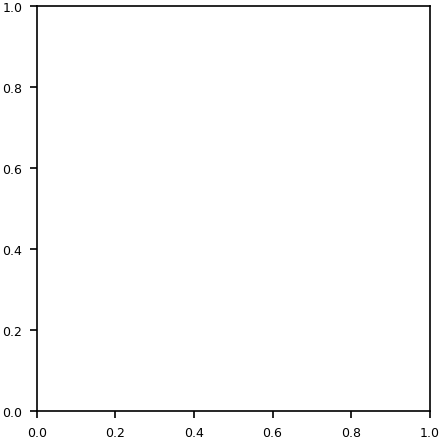

In [3]:
#plotting a single experiment
trait = "narea"
run_name = "matern12_PI" 
base_path = f"./output/bo/{trait}"
seeds = [0,1,2,3,4]

# Get data function
def getCol(col_name, run_name):
    _results = [pd.read_csv(f"{base_path}/{run_name}/result_{seed}.npy", encoding='utf-8')[col_name] for seed in seeds]
    _results = [np.array(_results[i]) for i in range(0,len(_results))]
    return _results

# Define linePlot function with linestyle parameter
def linePlot(ax, _results, label, linestyle):
    mean, var = np.mean(_results, axis=0), np.std(_results, axis=0)
    ax.plot(n, mean, label=label, linestyle=linestyle, alpha=0.5)
    ax.fill_between(n, mean - var,  mean + var, alpha=0.2)
    return
    

with plt.rc_context(bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)):
    fig, ax = plt.subplots(1,1, figsize=(3,3))

    n = getCol("n", run_name)[0]
    best = getCol("Best", run_name)
    #train_loss = getCol("train_loss")
    #val_loss = getCol("val_loss")

    linePlot(ax, best, label=run_name , linestyle='-')
    #linePlot(ax, train_loss, label=f"{run_name} train", linestyle='-')  # Solid line for training data
    #linePlot(ax, val_loss, label=f"{run_name} validation", linestyle='--')  # Dashed line for validation data
    
    #plot random
    n_random = getCol("n", "random")[0]
    best_random = getCol("Best", "random")
    linePlot(ax, best_random, label=run_name , linestyle='-')


    ax = ax
    ax.grid(True)
    ax.set_title(f"BO {run_name}") 
    ax.set_xlabel("N") 
    ax.set_ylabel("Max Heritability")
    #ax.legend(loc="lower right")

plt.show()

## Full Benchmarks: 

In [50]:
#For plotting a full sweep, double check that data files exist which you want to plot
seeds = 5
traits = ["sla"]
base_path = f"./output/5.5.2024/bo"

for acq_name in ["EI", "PI", "UCB-0.1", "UCB-0.2", "UCB-0.5"]:
    for kernel_name in ["matern52", "matern32", "rbf", "matern12"]:
        for trait in traits:
            trait = trait.lower()
            try:
                _results = [pd.read_csv(f"{base_path}/{trait}/{kernel_name}_{acq_name}/result_{seed}.npy", encoding='utf-8') for seed in range(seeds)]
            except Exception as e:
                print(e)

[Errno 2] No such file or directory: './output/5.5.2024/bo/sla/matern12_UCB-0.2/result_0.npy'


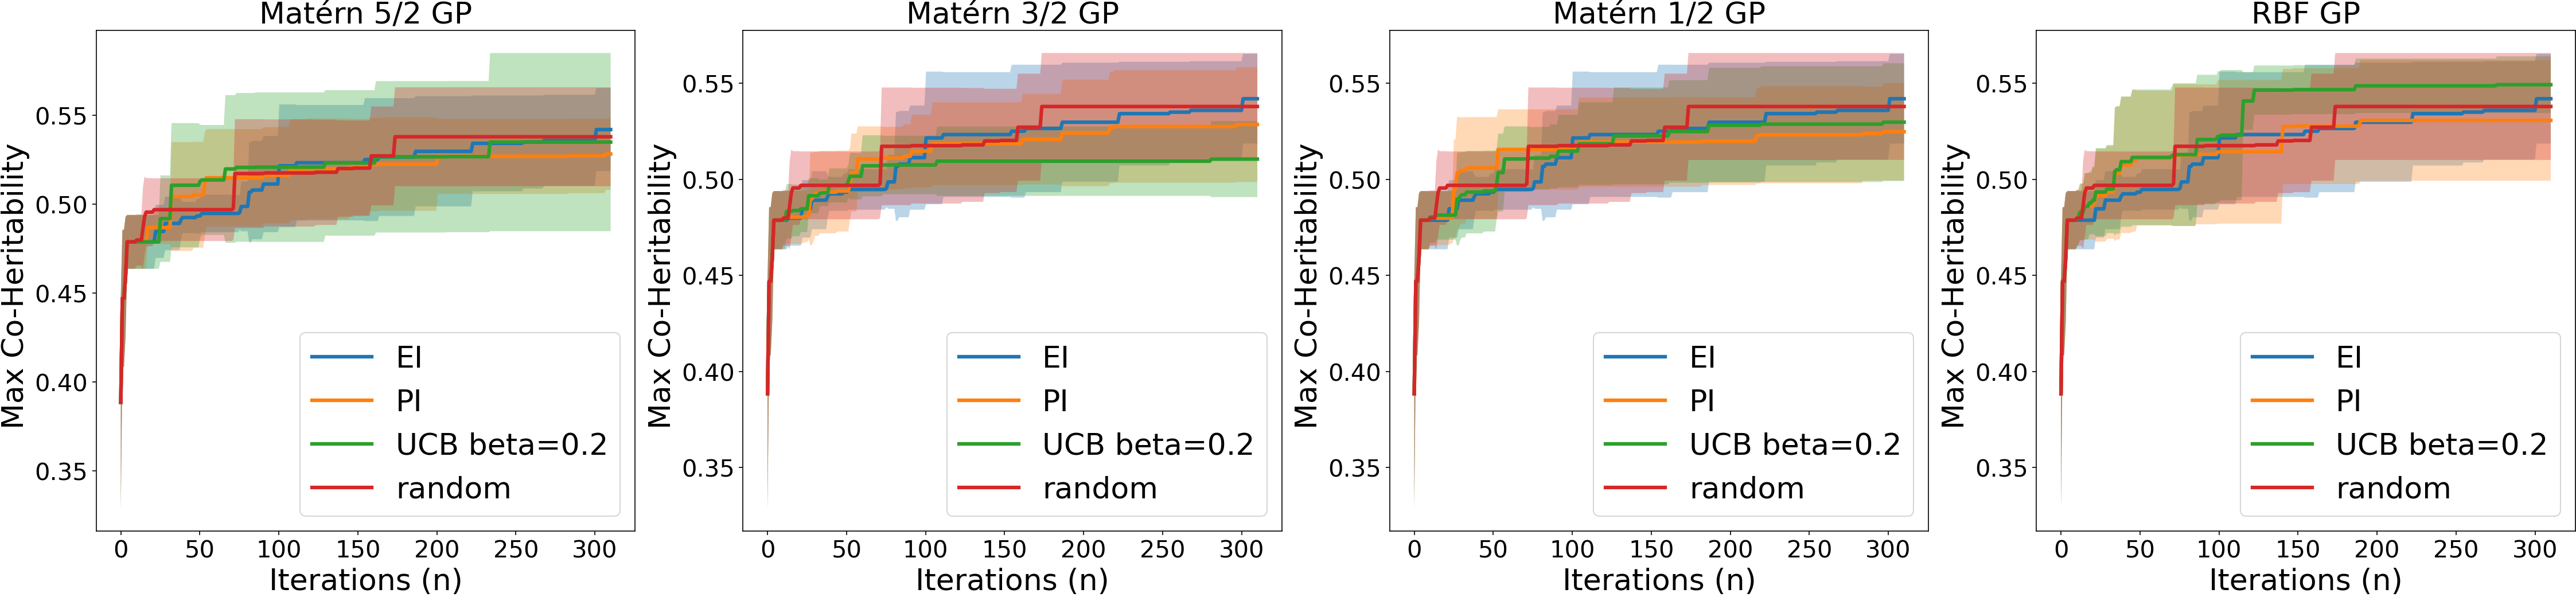

In [35]:
trait = "narea"
base_path = f"./output/5.5.2024/bo"
seeds = [0,1,2,3,4]

kernels = ["matern52", "matern32", "matern12", "rbf"]
acqs = ["EI", "PI", "UCB-0.2"]#"UCB-0.1", "UCB-0.2"]


alpha=0.1
line_width = 3
fig, axs = plt.subplots(1, len(kernels), figsize=(30, 7))
color_dict = {"EI": 'Pink', "PI": 'Blue', "KG": 'Green', 
              "UCB": 'Orange', "UCB-0.1": 'Red', "UCB-0.2": 'Green', "UCB-0.5": 'Orange'}
kernel_dic = {"matern52": "Matérn 5/2", "matern32": "Matérn 3/2", "matern12": "Matérn 1/2", "rbf": "RBF"}
acq_dic = {"EI": "EI", "PI": "PI", "UCB-0.5": "UCB beta=0.5", "UCB-0.1": "UCB beta=0.1", "UCB-0.2": "UCB beta=0.2"}

#BAYESIAN OPTIMIZATION
for k, kernel_name in enumerate(kernels):
    for a, acq_name in enumerate(acqs):
        botorch_results = [pd.read_csv(f"{base_path}/{trait}/{kernel_name}_{acq_name}/result_{seed}.npy", encoding='utf-8')["Best"] for seed in seeds]
        botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
        mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
        x_axis = np.linspace(0, len(mean), len(mean))

        color = color_dict[acq_name]
        axs[k].plot(x_axis, mean, label= f"{acq_dic[acq_name]}", linewidth=line_width) #, color=color)
        axs[k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color=color)

        # #graph elements
        # plt.plot([actual_max[trait]]*its ,linestyle='dashed', label="Best Co-heritabilty")
        # plt.plot ([top_01[trait]]*its ,linestyle='dashed', label="Top 1%")

        
    #plot random
    botorch_results = [pd.read_csv(f"{base_path}/{trait}/random/result_{seed}.npy", encoding='utf-8')["Best"] for seed in seeds]
    botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
    mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
    axs[k].plot(x_axis, mean, label= f"random", linewidth=line_width) #, color="black")
    axs[k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color="black")
    
    #Set title and labeles
    axs[k].set_title(f"{kernel_dic[kernel_name]} GP", fontsize=25) #Wavelength Ratio + {trait}
    axs[k].set_xlabel("Iterations (n)", fontsize=25) 
    axs[k].set_ylabel("Max Co-Heritability ", fontsize=25)
    axs[k].legend(loc="lower right", fontsize=25)
    axs[k].tick_params(axis='both', labelsize=20)
    #axs[k].set_ylim(0.7,1)
plt.show()

In [ ]:
# same kernel on the same plot

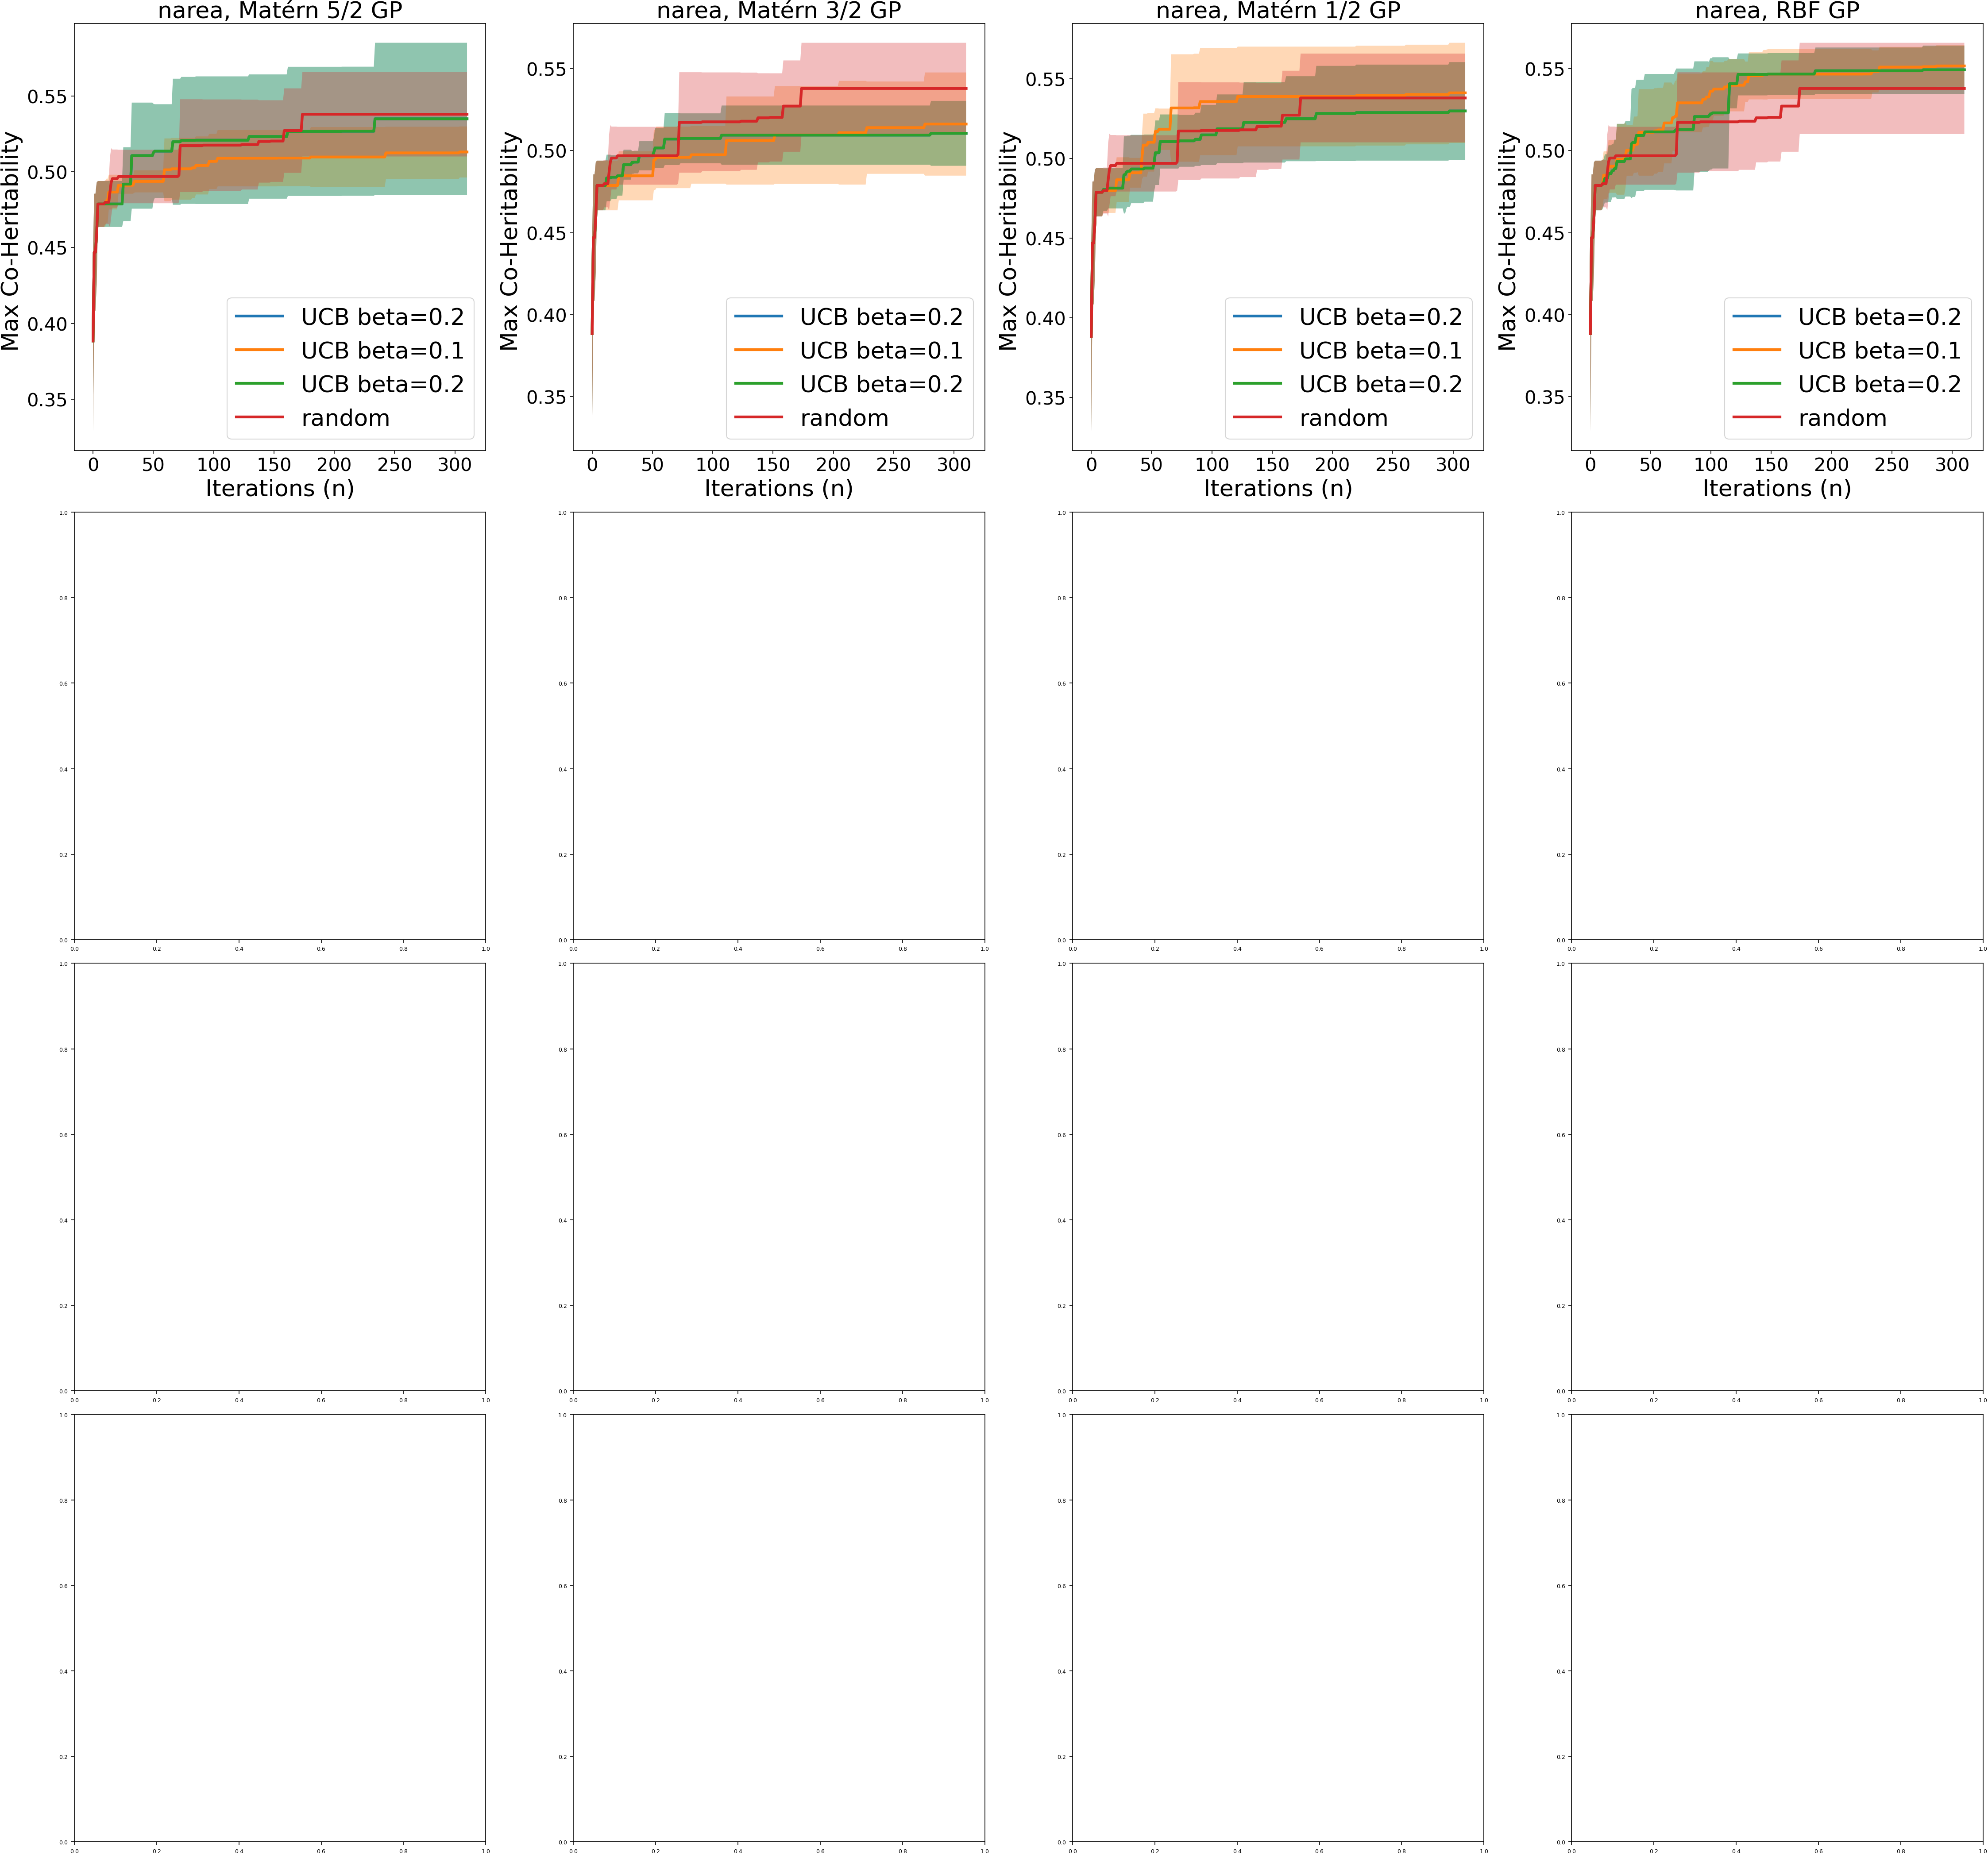

FileNotFoundError: [Errno 2] No such file or directory: './output/5.5.2024/bo/sla/matern12_UCB-0.2/result_0.npy'

In [43]:
traits = ["narea", "sla", "pn", "ps"]
base_path = f"./output/5.5.2024/bo"
seeds = [0,1,2,3,4]

kernels = ["matern52", "matern32", "matern12", "rbf"]
acqs = ["UCB-0.2", "UCB-0.1", "UCB-0.2"]


alpha=0.1
line_width = 3
fig, axs = plt.subplots(len(traits), len(kernels), figsize=(30, 28))
color_dict = {"EI": 'Pink', "PI": 'Blue', "KG": 'Green', 
              "UCB": 'Orange', "UCB-0.1": 'Red', "UCB-0.2": 'Green', "UCB-0.5": 'Orange'}
kernel_dic = {"matern52": "Matérn 5/2", "matern32": "Matérn 3/2", "matern12": "Matérn 1/2", "rbf": "RBF"}
acq_dic = {"EI": "EI", "PI": "PI", "UCB-0.5": "UCB beta=0.5", "UCB-0.1": "UCB beta=0.1", "UCB-0.2": "UCB beta=0.2"}

#BAYESIAN OPTIMIZATION
for t, trait in enumerate(traits):
    for k, kernel_name in enumerate(kernels):
        for a, acq_name in enumerate(acqs):
            botorch_results = [pd.read_csv(f"{base_path}/{trait}/{kernel_name}_{acq_name}/result_{seed}.npy", encoding='utf-8')["Best"] for seed in seeds]
            botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
            mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
            x_axis = np.linspace(0, len(mean), len(mean))

            color = color_dict[acq_name]
            axs[t,k].plot(x_axis, mean, label= f"{acq_dic[acq_name]}", linewidth=line_width) #, color=color)
            axs[t, k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color=color)


        #plot random
        botorch_results = [pd.read_csv(f"{base_path}/{trait}/random/result_{seed}.npy", encoding='utf-8')["Best"] for seed in seeds]
        botorch_results = [np.array(botorch_results[i]) for i in range(0,len(botorch_results))]
        mean, var = np.mean(botorch_results, axis=0), np.std(botorch_results, axis=0)
        axs[t, k].plot(x_axis, mean, label= f"random", linewidth=line_width) #, color="black")
        axs[t, k].fill_between(x_axis, mean - var,  mean + var, alpha=0.3) #, color="black")

        #Set title and labeles
        axs[t, k].set_title(f"{trait}, {kernel_dic[kernel_name]} GP", fontsize=25) #Wavelength Ratio + {trait}
        axs[t, k].set_xlabel("Iterations (n)", fontsize=25) 
        axs[t, k].set_ylabel("Max Co-Heritability ", fontsize=25)
        axs[t, k].legend(loc="lower right", fontsize=25)
        axs[t, k].tick_params(axis='both', labelsize=20)
        #axs[k].set_ylim(0.7,1)
    plt.show()